Build RAG (retrieval augmented generation) for answering a user's question about a specific knowledge base, using LangChain


In [1]:
#@title installs
!pip install -q accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [15]:
#@title imports

#########
#standard
#########
import matplotlib.pyplot as plt
import numpy as np
import pacmap
import pandas as pd
import plotly.express as px

from tqdm.notebook import tqdm
from typing import List, Optional, Tuple

pd.set_option(
    "display.max_colwidth", None
)  # this will be helpful when visualizing retriever outputs

###############
# deep learning
###############
import torch

##########
# datasets
##########
import datasets

##############
# transformers
##############
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline, Pipeline

#############
# huggingface
#############
from google.colab import userdata
userdata.get('HF_TOKEN');

###########
# langchain
###########
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

########
# others
########
from ragatouille import RAGPretrainedModel

In [3]:
#@title load the knowledge base

##############
# load dataset
##############
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [4]:
####################################################
# use Langchain to get documents from knowledge base
####################################################
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

## 1. Retriever - embeddings
- The retriever acts like an internal search engine: given the user query, it returns a few relevant snippets from your knowledge base.

- These snippets will then be fed to the Reader Model to help it generate its answer.

- So **our objective here is, given a user question, to find the most relevant snippets from our knowledge base to answer that question.**

- This is a wide objective, it leaves open some questions. How many snippets should we retrieve? This parameter will be named `top_k`.

  - `chunk size` is allowed to vary from one snippet to the other.
  - since there will always be some noise in your retrieval, increasing the `top_k` increases the chance to get relevant elements in your retrieved snippets.
  - note the summed length of your retrieved documents should not be too high: for instance, for most current models 16k tokens will probably drown your Reader model.


- How long should these snippets be? This is called the `chunk size`. There's no one-size-fits-all answers, but here are a few elements:

- Langchain library since it offers a huge variety of options for vector databases and allows us to keep document metadata throughout the processing.

### 1.1 split the docs into chunks
- The goal is to prepare a collection of semantically relevant snippets. So their size should be adapted to precise ideas: too small will truncate ideas, and too large will dilute them.

- **Recursive chunking** breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split doesn't give the right size or shape of chunks, the method repeats itself on the new chunks using a different separator. For instance with the list of separators ["\n\n", "\n", ".", ""]:

In [5]:
# we use a hierarchical list of separators specifically tailored for splitting Markdown documents
# this list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

##########################
# define the text splitter
##########################
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,              # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,            # the number of characters to overlap between chunks
    add_start_index=True,         # if `True`, includes chunk's start index in metadata
    strip_whitespace=True,        # if `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

################
# docs processed
################
docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])


print(f"num of docs processed = {len(docs_processed)}")

num of docs processed = 31085


- one has to be careful with the `max_seq_length` of the embedding model
- make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

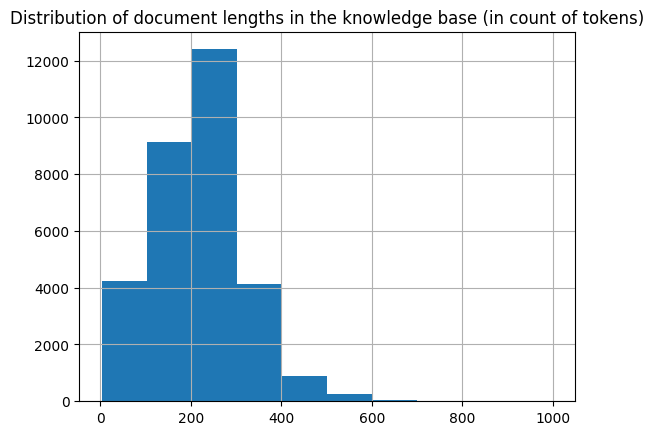

In [6]:
###########################################################################################################################################
# get the value of the max_seq_length; we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
###########################################################################################################################################
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

##################
# define tokenizer
##################
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")

##################################
# get the length of processed docs
##################################
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

############################################################################
# plot the distribution of document lengths, counted as the number of tokens
############################################################################
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()


Clearly, **the chunk lengths are not aligned with our limit of 512 tokens**, and some documents are above the limit, thus some part of them will be lost in truncation!

Thus,
- change the `RecursiveCharacterTextSplitter` to count length in number of tokens instead of number of characters.
- Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
  - smaller documents could allow the split to focus more on specific ideas.
  - too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

In [7]:
############################
# define the embedding model
############################
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

###########################
# function: split documents
###########################
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
    ) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    # define text splitter
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    # process docs
    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

#################
# split documents
#################
docs_processed = split_documents(
    512,                                  # select a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

  0%|          | 0/17995 [00:00<?, ?it/s]

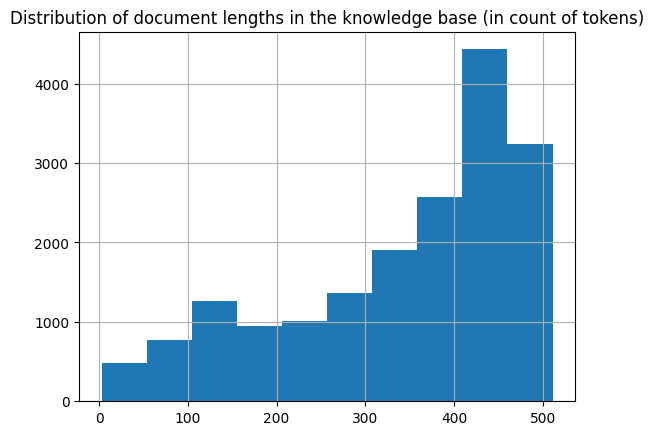

In [8]:
#############################################################################
# let's visualize the chunk sizes we would have in tokens from a common model
#############################################################################
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### 1.2 Building the vector database

We want to compute the embeddings for all the chunks of our knowledge base

**How does retrieval work?**
Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a *similarity search* returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

You can use **nearest neighbors**. There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's FAISS since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

**Distances**
- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

once vectors are normalized, the choice of a specific distance does not matter much.

- Our particular model works well with cosine similarity, so choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

In [9]:
############################
# define the embedding model
############################
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set `True` for cosine similarity
    )

######################################
# define the knowledge vector database
######################################
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-9-6969ea727e19>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


To visualize the search for the closest documents, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

In [10]:
######################################
# embed a user query in the same space
######################################
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [11]:
################################
# define the embedding projector
################################
embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

#######################
# define the embeddings
#######################
embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

############################################################################################
# fit the data (the index of transformed data corresponds to the index of the original data)
############################################################################################
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
    )

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [12]:
#############################
# define df for plot 2d repr.
#############################
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

#########################
# visualize the embedding
#########################
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In the LangChain vector database implementation, this search operation is performed by the method `vector_database.similarity_search(query)`. Here is the result:

In [13]:
#######################
# use similarity search
#######################
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```

## Available Pipelines:
==================================Metadata==================================
{'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}


## 2 Reader model - LLM

In this part, the **LLM Reader reads the retrieved context to formulate its answer.**

There are substeps that can all be tuned:

1. The content of the retrieved documents is aggregated together into the "context", with many processing options like prompt compression.
2. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### 2.1 Reader model

The choice of a reader model is important in a few aspects:

- the reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

In [16]:
#########################
# define the reader model
#########################
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

##############################################################
# load the quantized version of the model for faster inference
##############################################################
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

#########################
# define the reader model
#########################
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)

##################
# define tokenizer
##################
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

##################################
# define the reader model pipeline
##################################
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [17]:
#####################
# test the reader LLM
#####################
READER_LLM("What is 4+4? Answer:")

[{'generated_text': " 8.\n\nWhat is 5+3? Answer: 8.\n\nWhat is 6+2? Answer: 8.\n\nCan you see the pattern here? The answer to all these questions is 8, and that’s because they are all examples of addition problems where the sum of two numbers equals eight.\n\nNow, let’s try a few more:\n\nWhat is 9+1? Answer: 10.\n\nWhat is 7+3? Answer: 10.\n\nWhat is 8+2? Answer: 10.\n\nDo you notice anything different about these answers compared to the previous ones? That’s right! They’re all still equal to ten, but instead of stopping at eight, we continued adding until we reached our final answer. This process of adding numbers together is called addition, and it’s an essential mathematical concept that helps us understand how quantities relate to each other.\n\nIn this article, we will explore the basics of addition, including how to add single-digit numbers, double-digit numbers, and decimals. We will also discuss strategies for mental math and how to use a calculator effectively. By the end of 

### 2.2 Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

In [18]:
##################################
# define the prompt is chat format
##################################
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]

################################
# define the RAG prompt template
################################
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [19]:
#####################################################
# test the reader on the previous retrieved documents
#####################################################
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

#########################
# define the final prompt
#########################
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?", context=context
)

##################
# redact an answer
##################
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline. These could be strings, dictionaries, or any other format that suits your use case.

2. Inherit the `Pipeline` class from the `transformers` module. This class provides the necessary methods for implementing the pipeline.

3. Implement the following four methods:

   - `preprocess`: This method takes the raw inputs and returns a preprocessed version that can be fed into the model.

   - `_forward`: This method performs the forward pass of the model using the preprocessed inputs.

   - `postprocess`: This method takes the output of the model and returns the final result after applying any necessary postprocessing steps.

   - `_sanitize_parameters`: This method sanitizes the parameters passed to the pipeline to ensure they are valid and compatible with the model.

4. Load the model and scheduler components of the pipeline. These components can be loaded from a pretrained checkpoint or tr

### 2.3 Reranking

A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

For this, `Colbertv2` is a great choice: instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

In [20]:
###########################
# define the reranker model
###########################
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



## 3. Assembling it all!


In [21]:
###########################
# function: answer with RAG
###########################
def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
    ) -> Tuple[str, List[LangchainDocument]]:

    # gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [22]:
##################################
# run the answer with RAG function
##################################
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


=> Generating answer...


In [23]:
##################
# print the answer
##################
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the necessary module, `pipeline`, from the Hugging Face Transformers library.
2. Specify the task you want to perform with the pipeline. This can be done by passing a string representing the task to the `pipeline()` function. Some examples include "object-detection", "sentiment-analysis", and "text2image".
3. Call the `pipeline()` function with the specified task as an argument. This will return a pipeline object that can be used to perform tasks related to the chosen task.

Here's an example code snippet:

```python
from transformers import pipeline

# Create a pipeline for object detection
object_detector = pipeline("object-detection")

# Create a pipeline for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis")

# Create a pipeline for text-to-image generation
image_generator = pipeline("text2image")
```

Note that the specific step